# Bayes Classification Model

Per the project instructions, one of our models of choice must be a Bayes classification model. 

I'll be trying a handful of Naive Bayes classifiers: Multinomial, Complement and Bernoulli - trying each with a TfidfVectorizer and a CountVectorizer (default params on each) to see which performs best without hypertuning the parameters. The highest performing models will then be re-investigated as we GridSearch over the parameters to hopefully increase the model's accuracy. 

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

# https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [3]:
# read in clean data, inspect
data = pd.read_csv('./data/clean_subreddits.csv')

data.head(2)

,num_comments,score,selftext,subreddit,title,clean_selftext,clean_title,wordcount_clean_selftext,wordcount_clean_title
0,1,0,**Maybe it's *staged* right**?! We all know th...,C_S_T,Koch Brother and Trump biographer kicked out o...,maybe staged right know koch bros der juden co...,koch brother trump biographer kicked trump gol...,160,8
1,21,31,[Part 1: It Starts With Your Thinking](https:/...,C_S_T,How Not To Get Sick - Part 3: Discarding Your ...,part 1 start thinking http www reddit com r c_...,get sick part 3 discarding victim mentality,950,7


In [4]:
data['title'][910]

'Theory: The pandemic is being used as a catalyst to usher in the technocracy age of automation and artificial intelligence. (For better or for worse)'

In [5]:
# subreddit must be numeric val
data['subreddit'], vals = pd.factorize(data['subreddit'])

data['subreddit'].value_counts(normalize=True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

***BASELINE***

Our baseline accuracy score is 0.50. Essentially, since we have an even number of both classes, we could flip a coin and do a pretty decent job of predicting which subreddit the post text came from. Our goal is to create a model that outperforms a coinflip.

In [8]:
# set X & y
X = data['clean_selftext']
y = data['subreddit']

# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#check shape
print(X_train.shape, y_train.shape)

(750,) (750,)


In [12]:
# instantiate bayes models create a list for future iteration
mnb = MultinomialNB()
cnb = ComplementNB()
bnb = BernoulliNB()

bayes_est = [mnb, cnb, bnb]

In [51]:
# functions to instantiate and fit the estimator of choice
def cv_models(estimator):
    pipe = make_pipeline(CountVectorizer(), estimator)
    pipe.fit(X_train, y_train)
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    return estimator, train_score, test_score

def tfidf_models(estimator):
    pipe = make_pipeline(TfidfVectorizer(), estimator)
    pipe.fit(X_train, y_train)
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    return estimator, train_score, test_score

In [21]:
for i in bayes_est:
    print(cv_models(i))

(MultinomialNB(), 0.9133333333333333, 0.752)
(ComplementNB(), 0.9133333333333333, 0.752)
(BernoulliNB(), 0.7413333333333333, 0.552)


In [22]:
for i in bayes_est:
    print(tfidf_models(i))

(MultinomialNB(), 0.8786666666666667, 0.708)
(ComplementNB(), 0.8813333333333333, 0.716)
(BernoulliNB(), 0.7413333333333333, 0.552)


***Interpretation***:

Above we can see the output of two simple functions that fit and score Bayesian classifiers with their default hyperparameters, one with CountVectorizer and the other with TfidfVectorizer, and returns their training and test scores. Based on the results, it looks like Multinomial Naive Bayes and Complement Naive Bayes are the best models. CountVectorizer appears to perform better than the Tfidf Vectorizer. 

We will use GridSearchCV to tune these estimators and identify the best parameters in the hopes of increasing our testing accuracy. 

---

### **GridSearchCV to Optimize CountVectorizer/Bayes Combo Models**

Given the above results, we will now perform a GridSearch over the parameters in the hopes of increasing our testing accuracy. 

In [35]:
# scores w/no train_size 0.92/0.73
cv_pipe = make_pipeline(
    #CountVectorizer(binary=False, max_df=0.5, stop_words='english', ngram_range=(1,1)), 
    CountVectorizer(),
    MultinomialNB()
)

cv_params = {
    'countvectorizer__binary': [True, False],
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__max_features': [None, 100, 200],
    'countvectorizer__max_df': [0.5, 0.75, 1],
    'multinomialnb__alpha': [0, 0.5, 1.0],
    'multinomialnb__fit_prior': [True, False]
}


#cv_pipe.fit(X_train, y_train)
gs = GridSearchCV(estimator=cv_pipe, param_grid=cv_params, n_jobs=-1)

gs.fit(X_train, y_train)

print("Train Score: ", gs.score(X_train, y_train))
print('Test Score: ', gs.score(X_test, y_test))

Train Score:  0.9653333333333334
Test Score:  0.732


In [36]:
# identify the best parameters
print('Best Params: ', gs.best_params_)

Best Params:  {'countvectorizer__binary': True, 'countvectorizer__max_df': 0.75, 'countvectorizer__max_features': None, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'multinomialnb__alpha': 0.5, 'multinomialnb__fit_prior': True}


In [30]:
scores = cross_val_score(gs, X_test, y_test)

# https://scikit-learn.org/stable/modules/cross_validation.html
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


0.71 accuracy with a standard deviation of 0.06


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [31]:
# generate preds and see where they don't match up
# preds = gs.predict(X_test)

***Model Interpretation**

The discrepancy between the training and the testing scores indicates that our model is overfit. 

However, we don't particularly care about overfitting, so long as our accuracy is outperforming our baseline model (0.5) then it is performing acceptably. 

GridSearching for ideal parameters did not yield any increase in testing score accuracy. The defaults still perform best. 

### **ComplementNB**

#### So far, this model has best balance between training/test score

In [42]:
pipe = make_pipeline(CountVectorizer(ngram_range=(1,1)), ComplementNB())

cv_params = {
#     'countvectorizer__binary': [True, False],
#     'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4), (2, 2)],
    'countvectorizer__stop_words': [None, 'english'],
    #'countvectorizer__max_features': [None, 100, 200],
#     'countvectorizer__max_df': [0.5, 0.75, 1]
    'complementnb__alpha': [0, 0.5, 0.75, 1.0],
    'complementnb__fit_prior': [True, False],
    'complementnb__norm': [True, False]
    
}

gs = GridSearchCV(estimator=pipe, param_grid=cv_params, n_jobs=-1)

gs.fit(X_train, y_train)
#pipe.fit(X_train, y_train)
print("Train Score: ", gs.score(X_train, y_train))
print('Test Score: ', gs.score(X_test, y_test))

Train Score:  0.9386666666666666
Test Score:  0.756


In [43]:
gs.best_params_

{'complementnb__alpha': 0.5,
 'complementnb__fit_prior': True,
 'complementnb__norm': False,
 'countvectorizer__stop_words': None}

In [45]:
acc = balanced_accuracy_score(y_test, gs.predict(X_test))
acc

0.7578765368852459

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 1800x1800 with 0 Axes>

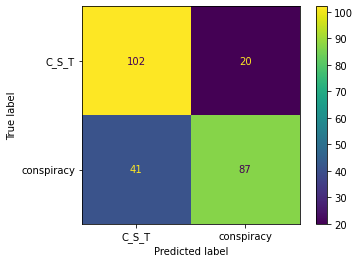

In [48]:
cm = confusion_matrix(y_test, gs.predict(X_test), labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=['C_S_T', 'conspiracy'])

plt.figure(figsize=(25, 25))
disp.plot();
plt.show();

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test), labels=[0, 1]).ravel()
print(tn, fp, fn, tp)

102 20 41 87


***Summary***

The ComplementNB Classifier yielded the best overall test score. We can see here that the model has a high false negative rate, and more often assigns actual conspiracy posts as C_S_T than it does the opposite (only half as many were predicted conspiracy when they were actually C_S_T). 

This is our best model of the Bayes Classifiers that we tried. This model was run with and without a StandardScaler, ultimately finding greater accuracy if the StandardScaler was excluded from the pipeline. In further modeling, we'll explore other, non-bayesian classifiers and compare the results. 

---
### **GridSearchCV with Tfidf Vectorizer & ComplementNB**

Just for fun, used the highest performing Tfidf/Bayes combo from the earlier default estimator functions. As expected, it did not perform our winning model (CountVectorizer/ComplementNB). 

In [24]:
tf_pipe = make_pipeline(TfidfVectorizer(), ComplementNB())

# tf_pipe.get_params()
# tf_params = {
#     'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4), (2, 2)],
#     'tfidfvectorizer__stop_words': [None, 'english'],
#     #'tfidfvectorizer__min_df': [0.5, 0.75, 1],
#     'tfidfvectorizer__norm': ['l1', 'l2'],
#     'tfidfvectorizer__use_idf': [True, False]
# }

# gs_2 = GridSearchCV(estimator=tf_pipe, param_grid=tf_params, n_jobs=-1)

tf_pipe.fit(X_train, y_train)

print("Train Score: ", tf_pipe.score(X_train, y_train))
print('Test Score: ', tf_pipe.score(X_test, y_test))

Train Score:  0.8813333333333333
Test Score:  0.716


***Summary*** 

This model did not outperform the others (not that I expected it to), but I included it to see if tuning the parameters could bring the testing accuracy closer to the CountVectorizer/Bayes combo models. 

We were unable to achieve that. Clearly, the CountVectorizer/Bayes combo(s) win out. 